## Разреженные матрицы

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc("font", size=14)
plt.rc("figure", figsize=(12, 7))

Довольно часто в вычислительной математике и смежных областях возникают линейные системы с матрицами, в которых большинство элементов &mdash; нули. Простейшими такими матрицами являются трехдиагональные и ленточные, треугольные матрицы.
    
             трехдиагональная                         ленточная                      треугольная
            [ * *           ]                     [ * * *         ]               [ *             ] 
            [ * * *         ]                     [ * * * *       ]               [ * *           ] 
            [   * * *       ]                     [ * * * * *     ]               [ * * *         ] 
            [     * * *     ]                     [ * * * * * *   ]               [ * * * *       ] 
            [       * * *   ]                     [   * * * * * * ]               [ * * * * *     ] 
            [         * * * ]                     [     * * * * * ]               [ * * * * * *   ] 
            [           * * ]                     [       * * * * ]               [ * * * * * * * ]
            
Данные матрицы обладают определенной стуктурой ненулевых элементов (положения ненулевых элементов называются еще *портретом* матрицы). Для линеных систем с данным типом матриц существуют быстрые методы решения со сложностью меньше $O(n^3)$ (обычного метода Гаусса)

К сожалению, часто на практике возникают разреженные матрицы без особой структуры в ненулевых элементах. Чаще всего эти матрицы получаются в результате дискретизации уравнений в частных производных на неструктурированных сетках.

Рассмотрим задачу интерполяции хаотичных многомерных данных. Пусть имеется набор
$$
\mathbf r_i, f(\mathbf r_i) \qquad i = 0, \dots, N-1,\quad \mathbf r_i \in [0,1]^3.
$$
Требуется построить функцию $P(\mathbf r)$, определенную на всем кубе $[0,1]^3$, проходящую через все точки.
Зададим вид функции $P(\mathbf r)$:
$$
P(\mathbf r) = \sum_{k=0}^{N-1} c_k \exp\left(-\frac{||\mathbf r - \mathbf r_k||^2}{2\sigma^2}\right)
$$
Будем считать, что $\sigma$ фиксированно, а $c_k$ необходимо выбрать так, чтобы $P(\mathbf r_i) = f(\mathbf r_i)$.
$$
\sum_{k=0}^{N-1} c_k \exp\left(-\frac{||\mathbf r_i - \mathbf r_k||^2}{2\sigma^2}\right) = f(\mathbf r_i),
\qquad i = 0, 1, \dots, N-1.
$$
Обозначим $f_i = f(\mathbf r_i), a_{ik}= \exp\left(-\frac{||\mathbf r_i - \mathbf r_k||^2}{2\sigma^2}\right)$.
Задача свелась к решению системы
$$
\sum_{k=0}^{N-1} a_{ik} c_k = f_i
$$
Однако при большом числе точек эта система слишком трудоемка. В этой задаче можно сделать одно упрощающее предположение: положим $a_{ik} = 0$, если точки $i$ и $k$ достаточно удалены друг от друга, скажем, больше, чем на $3\sigma$. Таким образом,
$$
a_{ik} = \begin{cases}
\exp\left(-\frac{||\mathbf r_i - \mathbf r_k||^2}{2\sigma^2}\right), &||\mathbf r_i - \mathbf r_k|| \leq 3\sigma,\\
0, &||\mathbf r_i - \mathbf r_k|| > 3\sigma
\end{cases}
$$

Оценим число ненулевых элементов, приходящихся на одну строку матрицы: объем единичного куба покрыт $N$ шарами объема $\frac{4\pi}{3} (3\sigma)^3$, а значит в одном таком шаре содержится в среднем
$$
m = \frac{4\pi N}{3} (3\sigma)^3 = 36\pi N \sigma^3
$$
точек. Значит, в среднем на одну строку матрицы приходится $m$ ненулевых элементов. Будем выбирать $\sigma$ таким образом, чтобы $m$ было примерно равно $20$.

In [2]:
def generate_points(n, m=20):
    sigma = (m / 36 / np.pi / n) ** (1/3)
    r = np.random.rand(n, 3)
    return r, sigma

def f_fun(r):
    x, y, z = r.T
    return x + 2 * y + 3 * z

### Форматы разреженных матриц

                                            [ 0 0 3 7 0 ]
                                            [ 1 0 2 3 5 ]           
                                        A = [ 4 0 0 2 0 ]
                                            [ 5 0 2 0 0 ]
                                            [ 4 0 0 0 0 ]

#### COO - Coordinate
Самый простой вариант хранения разреженной матрицы произвольной структуры &mdash; координатный формат. Матрица представляется в виде трех массивов размера **nnz**: массив ненулевых элементов **v**, массив соответствующих им строк **i** и столбцов **j**. В Python нумерация строк и столбцов матрицы начинается с нуля.
$$
A[i[k], j[k]] = v[k], \qquad k = 0, 1, ..., nnz - 1
$$

    i = [0 0 1 1 1 1 2 2 3 3 4]
    j = [2 3 0 2 3 4 0 3 0 2 0]
    v = [3 7 1 2 3 5 4 2 5 2 4]
    
Координатный формат проще остальных, но производить операции с матрицами в этом формате очень неудобно и долго.

#### CSR - Copressed Sparse Row
Наиболее рапространенный для вычислений формат. Хотя COO формат не обязывает сортировать элементы массивов **i**, **j**, в примере выше это было сделано. Заметим, что **i** содержит много повторяющихся значений, которые просто увеличиваются на 1 при переходе к следующей строке.

Для того, чтобы получить представление CSR, удалим из каждой строки ненулевые элементы, запоминая столбцы для ненулвых элементов.
    
    j = [2 3] [0 2 3 4] [0 3] [0 2] [0]
    v = [3 7] [1 2 3 5] [4 2] [5 2] [4]
    
Запишем эти сжатые строки в один массив, запоминая место, с которого начинается очередная строка в массиве **p**.
Для общности в массив **p** дописывают количество ненулевых элементов в конец.

    p = [0   2       6   8   10 11]
    j = [2 3 0 2 3 4 0 3 0 2 0]
    v = [3 7 1 2 3 5 4 2 5 2 4]

В таком представлении матрица задается формулой
$$
A[i, j[k]] = v[k], \qquad k = p[i], ..., p[i+1] - 1, \qquad i = 0, 1, \dots, n-1
$$

В этом формате быстро работают операции с целыми строками матрицы, но долго работают операции со столбцами. В частности, быстро работает операция умножения матрицы на вектор $y = Ax$, если $A$ задана в CSR формате.

#### CSC - Compressed Sparse Column
Похожий на CSR формат матрицы, только упаковывает элементы по столбцам. Фактически, если (**p**, **j**, **v**) задают матрицу $A$ в CSR формате, то эти же массивы задают $A^\top$ в CSC формате. Для симметричных матриц CSR и CSC представления совпадают.

In [3]:
def make_coo(r, sigma):
    th = (3*sigma)**2
    n = r.shape[0]
    
    row = [] # Массив номеров строк ненулевых элементов
    col = [] # Массив номеров столбцов ненулевых элементов
    sij = [] # Массив квадратов расстояний между точками, соответствующие ненулевым элементам
    
    for i in range(n):
        for j in range(n):
            rij2 = (r[i] - r[j]) @ (r[i] - r[j]) # ||r_i - r_j||^2
            if rij2 < th:
                row.append(i)
                col.append(j)
                sij.append(rij2)

    val = np.exp(-np.array(sij) / 2 / sigma**2)
    return sp.coo_matrix((val, (row, col)))

In [4]:
r, sigma = generate_points(2000)
f = f_fun(r)

In [5]:
%time A_coo = make_coo(r, sigma)

CPU times: user 22.7 s, sys: 36 ms, total: 22.7 s
Wall time: 22.7 s


Векторизуем эту функцию, как поступали ранее с плотной матрицей. Заодно запишем матрицу в CSR формате. Необходимо найти квадраты расстояний от точки $i$ до всех остальных
$$
s_j = ||\mathbf r_i - \mathbf r_j||^2, \qquad j = 0, 1, \dots, N-1
$$

Рассмотрим выражение

    r[i] - r
    
Данное выражение представляет собой матрицу размера n x 3. Для нахождения всех расстояний от точки i необходимо возвести элементы этой матрицы в квадрат и просуммировать по второму индексу.

Чтобы извлечь из массива только те элементы, которые удовлетворяют условиям, можно воспользоваться условной индексацией, например

    x[y < 5]
    
извлечет из массива **x** те элементы, которые находятся на тех же местах, где в массиве **y** находятся элементы, меньшие 5.

In [6]:
def make_csr(r, sigma):
    th = (3*sigma)**2
    n = r.shape[0]
    
    ptr = [0] # Указатель в массиве на начало очередной строки
    col = []  # Массив номеров столбцов ненулевых элементов
    sij = []  # Массив квадратов расстояний между точками, соответствующие ненулевым элементам
    
    js = np.arange(n) # Всевозможные столбцы. Из этого массива мы будем извлекать столбцы условно
    
    for i in range(n):
        # Возвести r[i] - r в квадрат и просуммировать по второму индексу (axis=1, нумерация с 0)
        si = np.sum((r[i] - r) * (r[i] - r), axis=1)
        
        rowcols = js[si < th] # Извлекаем столбцы, в которых выполняется условие si < th
        rowsi   = si[si < th] # И соответствующие значения квадратов расстояний
        
        col += list(rowcols)
        sij += list(rowsi)
        
        ptr.append(len(col)) # Запоминаем, на каком индексе закончилась i-я строка

    val = np.exp(-np.array(sij) / 2 / sigma**2)

    return sp.csr_matrix((val, col, ptr))

In [7]:
%time A_csr = make_csr(r, sigma)

CPU times: user 352 ms, sys: 0 ns, total: 352 ms
Wall time: 350 ms


Векторизация в этот раз дала выигриш в 60 раз, но при большом количестве точек сложность алгоритма все равно $O(N^2)$. Существуют специальные [деревья поиска](https://en.wikipedia.org/wiki/R-tree), позволяющие выполнить эту задачу быстрее, но мы не будем их касаться.

In [8]:
assert (A_csr - A_coo).nnz == 0, 'Матрицы A_csr и A_coo не совпадают!'

In [9]:
print('В среднем на строку приходится', A_csr.nnz / A_csr.shape[0], 'ненулевых элеметов')

В среднем на строку приходится 18.199 ненулевых элеметов


### Прямые методы для решения разреженных систем
Задача решения системы линейных уравнений с разреженной матрицей общего вида является крайне нетривиальной. Для этих задач разработано некоторое количество библиотек: UMFPACK, SuperLU. Первая существенно быстрее, но по лицензионным соображениям не совместима с scipy. Тем не менее, UMFPACK доступна в виде пакета [scikit-umfpack](https://pypi.python.org/pypi/scikit-umfpack). Библиотека SuperLU используется по умолчанию в scipy для решения разреженных систем линейных уравнений. 

Основная проблема при решении разреженных систем прямым методом заключается в том, что при выполнении аналога LU разложения количество ненулевых элементов в матрице вырастает. Число ненулевых элементов может быть уменьшено при определенном переупорядочении строк и столбцов матрицы. Построение такого переупорядочения является краегоугольным камнем алгоритмов разреженных LU разложений.

In [10]:
import scipy.sparse.linalg as la

In [11]:
%%time
lu = la.splu(A_csr)
print('Число ненулевых элементов выросло в', lu.nnz / A_csr.nnz, 'раз')

Число ненулевых элементов выросло в 16.22405077202044 раз
CPU times: user 412 ms, sys: 896 ms, total: 1.31 s
Wall time: 198 ms


/home/uranix/anaconda3/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:247: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Полезно посмотреть как изменяется портрет матрицы при переупорядочивании строк и стролбцов

In [12]:
r = np.empty_like(lu.perm_r)
c = np.empty_like(lu.perm_c)
c[lu.perm_c] = np.arange(len(c))
r[lu.perm_r] = np.arange(len(r))

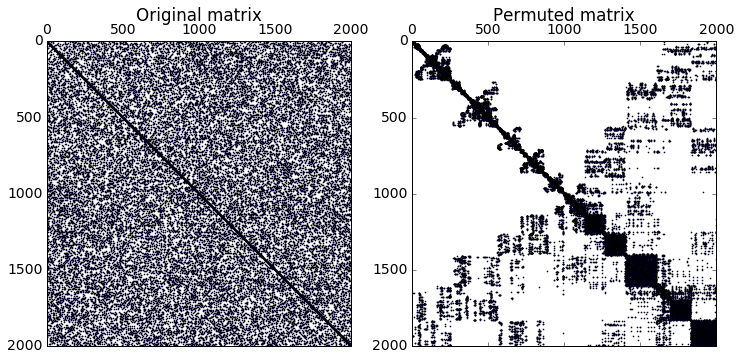

In [13]:
plt.subplot(1, 2, 1)
plt.spy(A_csr, markersize=1)
plt.title('Original matrix')
plt.subplot(1, 2, 2)
plt.spy(A_csr[r, :][:, c], markersize=1)
plt.title('Permuted matrix')

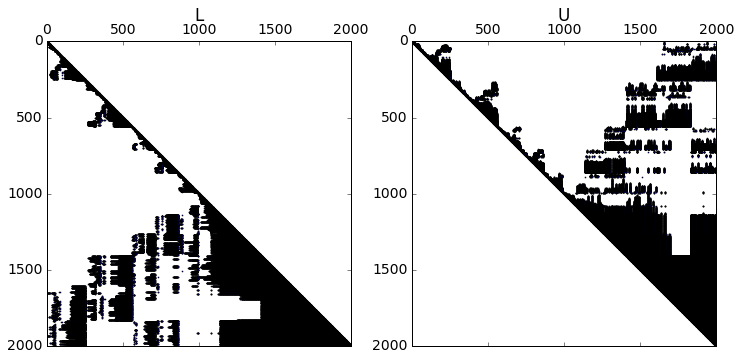

In [14]:
plt.subplot(1, 2, 1)
plt.spy(lu.L, markersize=1)
plt.title('L')
plt.subplot(1, 2, 2)
plt.spy(lu.U, markersize=1)
plt.title('U')

Можно было найти решение и в одно действие **la.spsolve(A, f)**, но тогда не удается получить информацию о разложении

In [15]:
%%time
xtrue = lu.solve(f)

CPU times: user 0 ns, sys: 12 ms, total: 12 ms
Wall time: 4.37 ms


In [16]:
print('Норма невязки', np.linalg.norm(f - A_csr @ xtrue))

Норма невязки 5.70747775632e-14


<h1 style="color:red">Задание 1</h1>
Для набора значений $N = 100 \div 5000$ сгенерировать матрицу системы, выполнить её разреженное LU разложение и определить количество ненулевых элементов в ней. Определить как растет количество ненулевых элементов в LU разложении с ростом размера матрицы. Оценить размер системы N, при которых под хранение LU разложения не будет хватать 4Гб оперативной памяти.
<h1 style="color:red">Задание 2</h1>
Для набора значений $N = 100 \div 5000$ сгенерировать матрицу системы, выполнить её разреженное LU разложение и определить количество ненулевых элементов в ней. Измерить время, затраченное на выполнение разложения, найти асимптотику этого времени в зависимости от размера матрицы.